图像加载成功，尺寸: (256, 256)
Stage1 最佳h值: 13.3, PSNR提升: 1.3dB

PSNR对比:
- 噪声图像: 20.6 dB
- 第一阶段: 21.9 dB (提升 +1.3 dB)
- 第二阶段: 25.0 dB (累计提升 +4.3 dB)


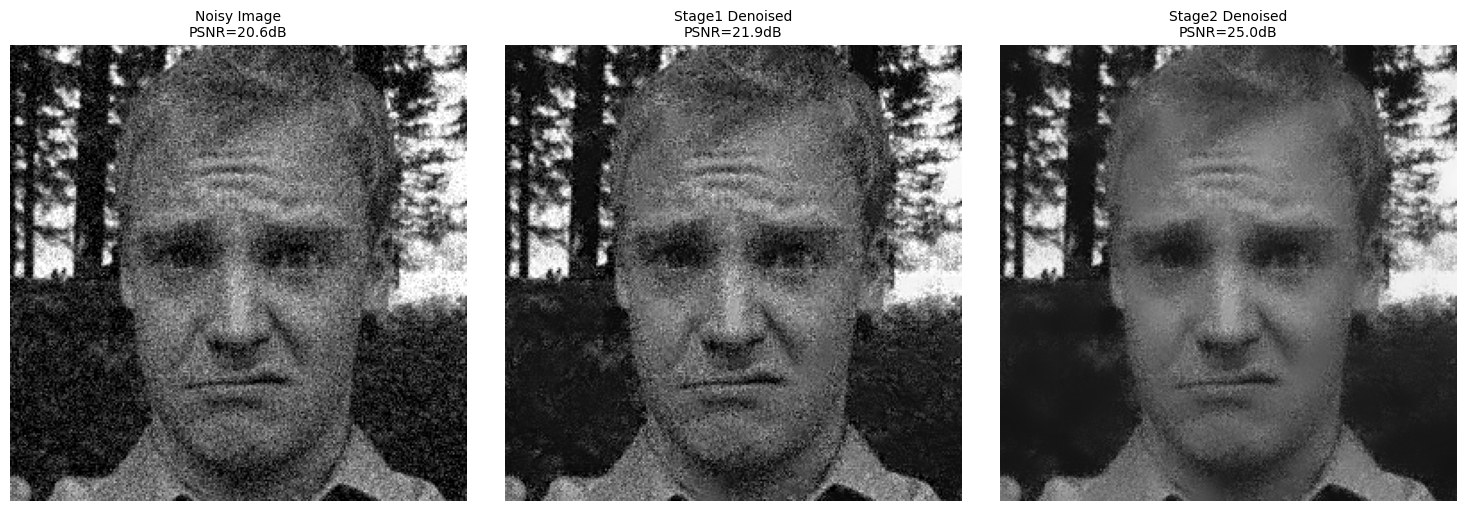

In [4]:
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
import os

def load_image(image_path):
    """安全加载图像函数"""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"路径不存在: {image_path}")
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"图像加载失败，请检查文件格式: {image_path}")
    return img

def add_gaussian_noise(image, sigma=25):
    """添加高斯噪声（确保可复现）"""
    np.random.seed(42)  # 固定随机种子
    noise = np.random.normal(0, sigma, image.shape).astype(np.float32)
    return np.clip(image.astype(np.float32) + noise, 0, 255).astype(np.uint8)

def conservative_stage1(clean_img, noisy_img, sigma):
    """保守的第一阶段去噪"""
    baseline_psnr = psnr(clean_img, noisy_img)
    for h in np.linspace(5, 30, 10):
        denoised = cv2.fastNlMeansDenoising(noisy_img, h=h)
        current_psnr = psnr(clean_img, denoised)
        if current_psnr > baseline_psnr + 1.0:
            print(f"Stage1 最佳h值: {h:.1f}, PSNR提升: {current_psnr - baseline_psnr:.1f}dB")
            return denoised
    return noisy_img

def conservative_stage2(clean_img, stage1_img, sigma):
    """保守的第二阶段去噪"""
    baseline_psnr = psnr(clean_img, stage1_img)
    
    # 尝试导向滤波
    if hasattr(cv2, 'ximgproc'):
        guided = cv2.ximgproc.guidedFilter(
            guide=stage1_img, 
            src=stage1_img, 
            radius=5, 
            eps=sigma**2
        )
        if psnr(clean_img, guided) > baseline_psnr:
            return guided
    
    
    return cv2.fastNlMeansDenoising(stage1_img, h=10)

# =============================================
# main function
# =============================================
if __name__ == "__main__":
    # 1. 设置您的图像路径
    image_path = r"D:/Study/washu/courses/543T_algorithm_for_nonlinear_optimization/project/sample2.jpg"
    
    try:
        # 2. 加载图像
        clean_img = load_image(image_path)
        print(f"图像加载成功，尺寸: {clean_img.shape}")
        
        # 3. 添加噪声
        noisy_img = add_gaussian_noise(clean_img, sigma=25)
        noisy_psnr = psnr(clean_img, noisy_img)
        
        # 4. 两阶段去噪
        stage1 = conservative_stage1(clean_img, noisy_img, 25)
        stage1_psnr = psnr(clean_img, stage1)
        
        stage2 = conservative_stage2(clean_img, stage1, 25)
        stage2_psnr = psnr(clean_img, stage2)
        
        # 5. 打印结果
        print("\nPSNR对比:")
        print(f"- 噪声图像: {noisy_psnr:.1f} dB")
        print(f"- 第一阶段: {stage1_psnr:.1f} dB (提升 {stage1_psnr - noisy_psnr:+.1f} dB)")
        print(f"- 第二阶段: {stage2_psnr:.1f} dB (累计提升 {stage2_psnr - noisy_psnr:+.1f} dB)")
        
        # 6. 可视化
        plt.figure(figsize=(15, 5))
        images = [noisy_img, stage1, stage2]
        titles = [
            f"Noisy Image\nPSNR={noisy_psnr:.1f}dB",
            f"Stage1 Denoised\nPSNR={stage1_psnr:.1f}dB",
            f"Stage2 Denoised\nPSNR={stage2_psnr:.1f}dB"
        ]
        
        for i, (img, title) in enumerate(zip(images, titles), 1):
            plt.subplot(1, 3, i)
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            plt.title(title, fontsize=10)
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig('denoising_results.jpg', dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"\n错误发生: {str(e)}")
        print("故障排除建议:")
        print("1. 检查路径是否包含中文或特殊字符")
        print("2. 确认文件扩展名与实际格式匹配")
        print("3. 尝试用绝对路径，例如: r'C:\\path\\to\\image.jpg'")

图像加载成功，尺寸: (256, 256)
Stage1 最佳h值: 13.3, PSNR提升: 1.3dB

PSNR & SSIM 对比:
- 噪声图像:  PSNR=20.6 dB, SSIM=0.4076
- 第一阶段:  PSNR=21.9 dB (+1.3 dB), SSIM=0.4883
- 第二阶段:  PSNR=25.0 dB (+4.3 dB), SSIM=0.6456


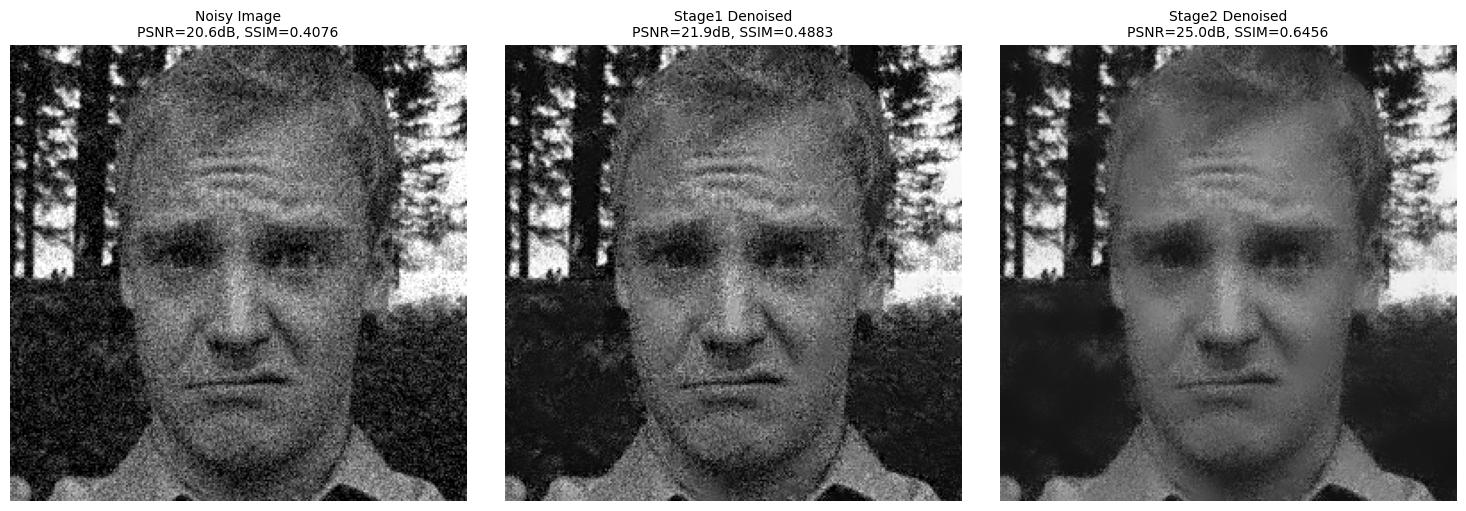

In [5]:
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import os

def load_image(image_path):
    """安全加载图像函数"""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"路径不存在: {image_path}")
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"图像加载失败，请检查文件格式: {image_path}")
    return img

def add_gaussian_noise(image, sigma=25):
    """添加高斯噪声（确保可复现）"""
    np.random.seed(42)  # 固定随机种子
    noise = np.random.normal(0, sigma, image.shape).astype(np.float32)
    return np.clip(image.astype(np.float32) + noise, 0, 255).astype(np.uint8)

def conservative_stage1(clean_img, noisy_img, sigma):
    """保守的第一阶段去噪"""
    baseline_psnr = psnr(clean_img, noisy_img)
    for h in np.linspace(5, 30, 10):
        denoised = cv2.fastNlMeansDenoising(noisy_img, h=h)
        current_psnr = psnr(clean_img, denoised)
        if current_psnr > baseline_psnr + 1.0:
            print(f"Stage1 最佳h值: {h:.1f}, PSNR提升: {current_psnr - baseline_psnr:.1f}dB")
            return denoised
    return noisy_img

def conservative_stage2(clean_img, stage1_img, sigma):
    """保守的第二阶段去噪"""
    baseline_psnr = psnr(clean_img, stage1_img)
    
    # 尝试导向滤波
    if hasattr(cv2, 'ximgproc'):
        guided = cv2.ximgproc.guidedFilter(
            guide=stage1_img, 
            src=stage1_img, 
            radius=5, 
            eps=sigma**2
        )
        if psnr(clean_img, guided) > baseline_psnr:
            return guided
    
    return cv2.fastNlMeansDenoising(stage1_img, h=10)

# =============================================
# main function
# =============================================
if __name__ == "__main__":
    # 1. 设置您的图像路径
    image_path = r"D:/Study/washu/courses/543T_algorithm_for_nonlinear_optimization/project/sample2.jpg"
    
    try:
        # 2. 加载图像
        clean_img = load_image(image_path)
        print(f"图像加载成功，尺寸: {clean_img.shape}")
        
        # 3. 添加噪声
        noisy_img = add_gaussian_noise(clean_img, sigma=25)
        noisy_psnr = psnr(clean_img, noisy_img)
        noisy_ssim = ssim(clean_img, noisy_img, data_range=255)
        
        # 4. 两阶段去噪
        stage1 = conservative_stage1(clean_img, noisy_img, 25)
        stage1_psnr = psnr(clean_img, stage1)
        stage1_ssim = ssim(clean_img, stage1, data_range=255)
        
        stage2 = conservative_stage2(clean_img, stage1, 25)
        stage2_psnr = psnr(clean_img, stage2)
        stage2_ssim = ssim(clean_img, stage2, data_range=255)
        
        # 5. 打印结果
        print("\nPSNR & SSIM 对比:")
        print(f"- 噪声图像:  PSNR={noisy_psnr:.1f} dB, SSIM={noisy_ssim:.4f}")
        print(f"- 第一阶段:  PSNR={stage1_psnr:.1f} dB ({stage1_psnr - noisy_psnr:+.1f} dB), SSIM={stage1_ssim:.4f}")
        print(f"- 第二阶段:  PSNR={stage2_psnr:.1f} dB ({stage2_psnr - noisy_psnr:+.1f} dB), SSIM={stage2_ssim:.4f}")
        
        # 6. 可视化
        plt.figure(figsize=(15, 5))
        images = [noisy_img, stage1, stage2]
        titles = [
            f"Noisy Image\nPSNR={noisy_psnr:.1f}dB, SSIM={noisy_ssim:.4f}",
            f"Stage1 Denoised\nPSNR={stage1_psnr:.1f}dB, SSIM={stage1_ssim:.4f}",
            f"Stage2 Denoised\nPSNR={stage2_psnr:.1f}dB, SSIM={stage2_ssim:.4f}"
        ]
        
        for i, (img, title) in enumerate(zip(images, titles), 1):
            plt.subplot(1, 3, i)
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            plt.title(title, fontsize=10)
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig('denoising_results_with_ssim.jpg', dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"\n错误发生: {str(e)}")
        print("故障排除建议:")
        print("1. 检查路径是否包含中文或特殊字符")
        print("2. 确认文件扩展名与实际格式匹配")
        print("3. 尝试用绝对路径，例如: r'C:\\path\\to\\image.jpg'")


图像加载成功，尺寸: (256, 256)
Stage1 最佳h值: 13.3, PSNR提升: 1.3dB

PSNR & SSIM 对比:
- 噪声图像:  PSNR=20.6 dB, SSIM=0.4076
- 第一阶段:  PSNR=21.9 dB (+1.3 dB), SSIM=0.4883
- 第二阶段:  PSNR=25.0 dB (+4.3 dB), SSIM=0.6456


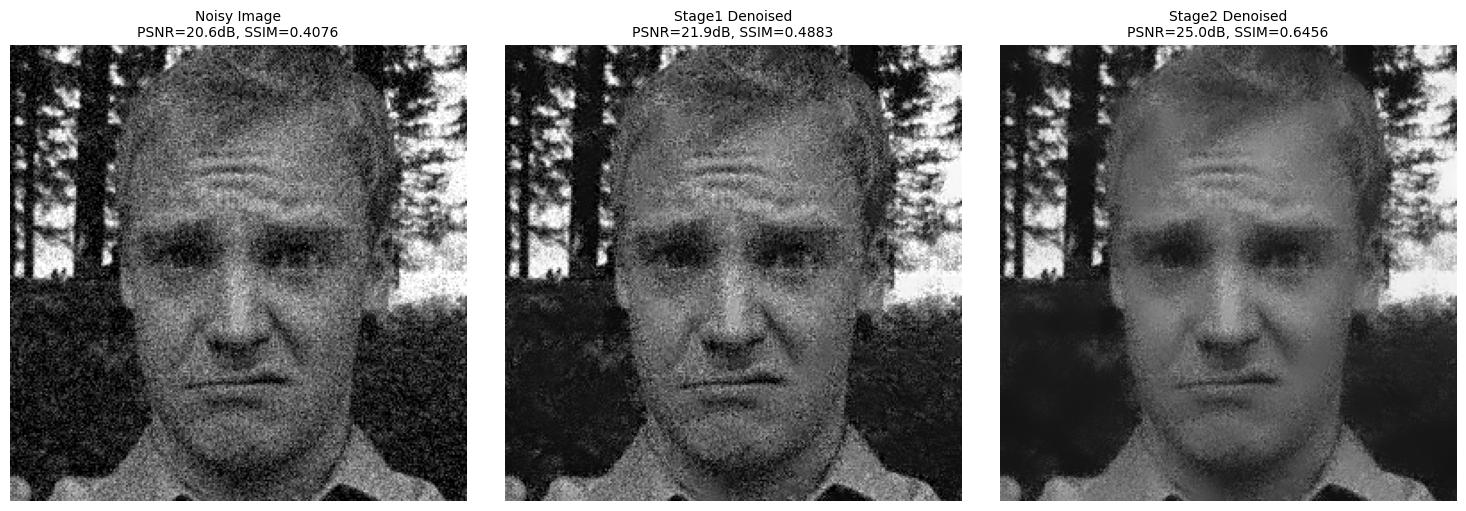


程序运行时间: 3.03 秒


In [7]:
import time  # 顶部加上

start_time = time.time()  # 程序开始前记一下时间

# —— 你的原来的完整程序内容，不用改 —— 
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import os

def load_image(image_path):
    """安全加载图像函数"""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"路径不存在: {image_path}")
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"图像加载失败，请检查文件格式: {image_path}")
    return img

def add_gaussian_noise(image, sigma=25):
    """添加高斯噪声（确保可复现）"""
    np.random.seed(42)  # 固定随机种子
    noise = np.random.normal(0, sigma, image.shape).astype(np.float32)
    return np.clip(image.astype(np.float32) + noise, 0, 255).astype(np.uint8)

def conservative_stage1(clean_img, noisy_img, sigma):
    """保守的第一阶段去噪"""
    baseline_psnr = psnr(clean_img, noisy_img)
    for h in np.linspace(5, 30, 10):
        denoised = cv2.fastNlMeansDenoising(noisy_img, h=h)
        current_psnr = psnr(clean_img, denoised)
        if current_psnr > baseline_psnr + 1.0:
            print(f"Stage1 最佳h值: {h:.1f}, PSNR提升: {current_psnr - baseline_psnr:.1f}dB")
            return denoised
    return noisy_img

def conservative_stage2(clean_img, stage1_img, sigma):
    """保守的第二阶段去噪"""
    baseline_psnr = psnr(clean_img, stage1_img)
    
    # 尝试导向滤波
    if hasattr(cv2, 'ximgproc'):
        guided = cv2.ximgproc.guidedFilter(
            guide=stage1_img, 
            src=stage1_img, 
            radius=5, 
            eps=sigma**2
        )
        if psnr(clean_img, guided) > baseline_psnr:
            return guided
    
    return cv2.fastNlMeansDenoising(stage1_img, h=10)

# =============================================
# main function
# =============================================
if __name__ == "__main__":
    # 1. 设置您的图像路径
    image_path = r"D:/Study/washu/courses/543T_algorithm_for_nonlinear_optimization/project/sample2.jpg"
    
    try:
        # 2. 加载图像
        clean_img = load_image(image_path)
        print(f"图像加载成功，尺寸: {clean_img.shape}")
        
        # 3. 添加噪声
        noisy_img = add_gaussian_noise(clean_img, sigma=25)
        noisy_psnr = psnr(clean_img, noisy_img)
        noisy_ssim = ssim(clean_img, noisy_img, data_range=255)
        
        # 4. 两阶段去噪
        stage1 = conservative_stage1(clean_img, noisy_img, 25)
        stage1_psnr = psnr(clean_img, stage1)
        stage1_ssim = ssim(clean_img, stage1, data_range=255)
        
        stage2 = conservative_stage2(clean_img, stage1, 25)
        stage2_psnr = psnr(clean_img, stage2)
        stage2_ssim = ssim(clean_img, stage2, data_range=255)
        
        # 5. 打印结果
        print("\nPSNR & SSIM 对比:")
        print(f"- 噪声图像:  PSNR={noisy_psnr:.1f} dB, SSIM={noisy_ssim:.4f}")
        print(f"- 第一阶段:  PSNR={stage1_psnr:.1f} dB ({stage1_psnr - noisy_psnr:+.1f} dB), SSIM={stage1_ssim:.4f}")
        print(f"- 第二阶段:  PSNR={stage2_psnr:.1f} dB ({stage2_psnr - noisy_psnr:+.1f} dB), SSIM={stage2_ssim:.4f}")
        
        # 6. 可视化
        plt.figure(figsize=(15, 5))
        images = [noisy_img, stage1, stage2]
        titles = [
            f"Noisy Image\nPSNR={noisy_psnr:.1f}dB, SSIM={noisy_ssim:.4f}",
            f"Stage1 Denoised\nPSNR={stage1_psnr:.1f}dB, SSIM={stage1_ssim:.4f}",
            f"Stage2 Denoised\nPSNR={stage2_psnr:.1f}dB, SSIM={stage2_ssim:.4f}"
        ]
        
        for i, (img, title) in enumerate(zip(images, titles), 1):
            plt.subplot(1, 3, i)
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            plt.title(title, fontsize=10)
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig('denoising_results_with_ssim.jpg', dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"\n错误发生: {str(e)}")
        print("故障排除建议:")
        print("1. 检查路径是否包含中文或特殊字符")
        print("2. 确认文件扩展名与实际格式匹配")
        print("3. 尝试用绝对路径，例如: r'C:\\path\\to\\image.jpg'")


end_time = time.time()  # 程序跑完后记一下时间
print(f"\n程序运行时间: {end_time - start_time:.2f} 秒")
